In [1]:
import numpy as np
from matplotlib import pyplot as plt

from skimage.transform import rescale, resize, radon, iradon
from scipy.stats import mode

from utils2 import *
import h5py

/home/everett/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


# Load Data.

Center finder works on 2D sinograms so select a sinogram along the y axis and load the data as (x, theta)

In [2]:
#h_sino = h5py.File('./sinograms/tomo_00001/tomo_00001.h5', 'r')
data = np.load('./sinograms/tomo_00064_to_00067/tomo_00066.npy')
#h_sino = h5py.File('./phantoms/phantom_00002/phantom_00002.h5','r')
#data, theta = tomobank_phantom_sino('./phantoms/phantom_00008/phantom_00008.h5')
print(data.shape)
#print(np.max(theta))

(350, 10, 450)


# Center finding on data and data with simulated.

/home/everett/anaconda3/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


Contrast ratio of input data:            0.2311438162813765
Contrast ratio of low exposure data:     1.6263032587282567e-19 

Contrast ratio of input row sum:         3.243867278740139e-13
Contrast ratio of low exposure row sum:  9.405995947397993e-18


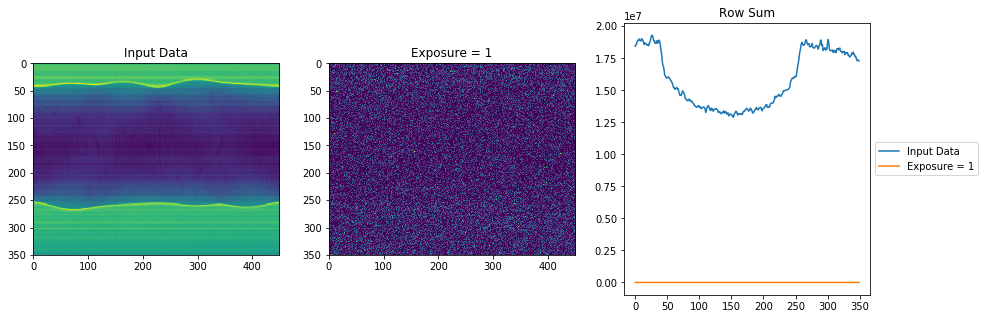

In [3]:
## Define exposure
exposure = 1

## Choose to sum along Y axis or to select a slice 
sinogram = data[:,0,:] #select a slice
image_center = sinogram.shape[0]/2

## Add noise
sinogram_noise, sinogram_noise_snr = add_noise2(sinogram, exposure, bit_depth = 8)

## Sum along theta
rowsum = np.sum(sinogram, axis=1)
rowsum_n = np.sum(sinogram_noise, axis=1)

## Print contrast ratio of arrays
## Contrast ratio is defined as the ratio of the max difference pixel values to
## the difference between minimum and maximum allowed values for the arrays dtype

print('Contrast ratio of input data:           ',  contrast_ratio(sinogram))
print('Contrast ratio of low exposure data:    ', contrast_ratio(sinogram_noise), '\n')
print('Contrast ratio of input row sum:        ',  contrast_ratio(rowsum))
print('Contrast ratio of low exposure row sum: ', contrast_ratio(rowsum_n))

## Plot ##
imimplot(sinogram, sinogram_noise, (rowsum, rowsum_n),
         ('Input Data', 'Exposure = ' + str(exposure)), title = 'Row Sum')

# Select window size, shifting range. Find center

Sinogram center =  [151.46697972]
Sinogram_n center =  [152.25171967]


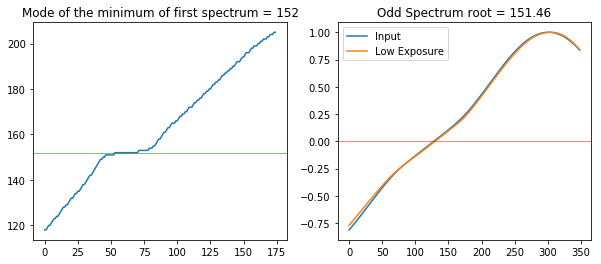

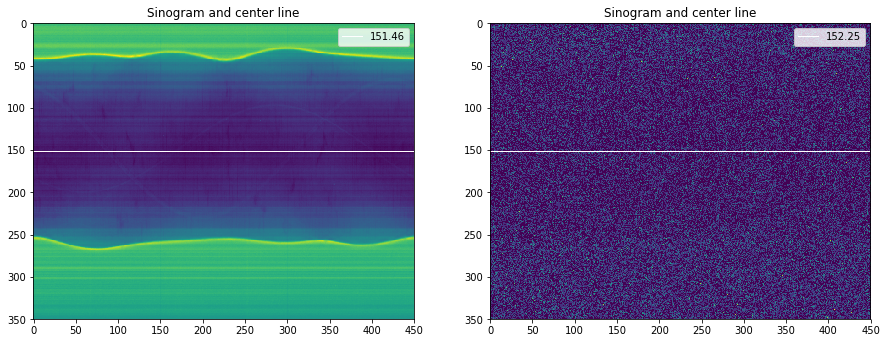

In [4]:
## Define scan area and range
window = sinogram_noise.shape[0]//2
shifting_range = sinogram_noise.shape[0]-window

## Collect the 1st FFT bin
bins = []
bins_n = []
for i in range(shifting_range):
    bins.append(window_bins(sinogram, window, i, fbins = [1])[0])
    bins_n.append(window_bins(sinogram_noise, window, i, fbins = [1])[0])

## Fit curve to find zero crossing and thus center.
root, spline = spline_root(np.imag(bins), window)
root_n, spline_n = spline_root(np.imag(bins_n), window)


print('Sinogram center = ', root)
print('Sinogram_n center = ', root_n)

fsm = first_spectrum_min(sinogram_noise, window)
fsm_mode = mode(fsm)[0][0]
plt.figure(figsize=(10,4))
plt.subplot(121)
plt.plot(fsm)
plt.axhline(fsm_mode, color='g', linewidth = .5)
plt.title('Mode of the minimum of first spectrum = ' + str(fsm_mode))
plt.subplot(122)
plt.plot(np.arange(len(np.imag(bins)))*2,np.imag(bins)/np.max(np.imag(bins)), label = 'Input')
plt.plot(np.arange(len(np.imag(bins_n)))*2,np.imag(bins_n)/np.max(np.imag(bins_n)), label = 'Low Exposure')
plt.title('Odd Spectrum root = ' + str(root[0])[0:6])
plt.axhline(0, color = 'r', linewidth = .5)
plt.legend()
plt.show()

plt.figure(figsize=(15,15))
plt.subplot(121)
plt.imshow(sinogram)
plt.title('Sinogram and center line')
plt.axhline(root, color='w', linewidth = 1, label = str(root[0])[0:6])
plt.legend()
plt.subplot(122)
plt.imshow(sinogram_noise)
plt.title('Sinogram and center line')
plt.axhline(root, color='w', linewidth = 1, label = str(root_n[0])[0:6])
plt.legend()
plt.show()



# Plot the rowsum, fft[1] spectrum, and its even and odd components.

## This was for playing around with different spectra

In [ ]:
#plots = list(np.arange(10)+np.floor(root-5)-window//2)
#DC_all, SYM_all = shift(sinogram_noise, window, plot=plots)